<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
    <br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Artifical Intelligence - Dr. Mohammad Hossein Rohban
</font>
<br/>
<br/>
Fall 2021

</div>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Practical Assignment 4 - AutoEncoder
            	<br/>
			</font>
    <br/>
    <br/>
<font size=4>
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

# Personal Data

In [1]:
# Set your student number
student_number = 98101074
Name = 'Mohammad Javad'
Last_Name = 'Hezareh'

# Rules
- You **are** allowed to add or remove cells.
- By running the cell below, you can see if your jupyter file is accepted or not. This cell will also **generate a python file which you'll have to upload to Quera** (as well as your jupyter file). The python file will later be validated and if the code in both files doesn't match, **your Practical Assignment won't be graded**.

In [2]:
# remember to save your jupyter file before running this script
from Helper_codes.validator import *

python_code = extract_python("./Q3.ipynb")
with open(f'python_code_Q3_{student_number}.py', 'w') as file:
    file.write(python_code)

your file will be graded


# Autoencoders (25 Points Extra)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import tqdm

from typing import Tuple
from torch.utils.data import Dataset, DataLoader

<font size=4>
Author: Ahmad Salimi
			<br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

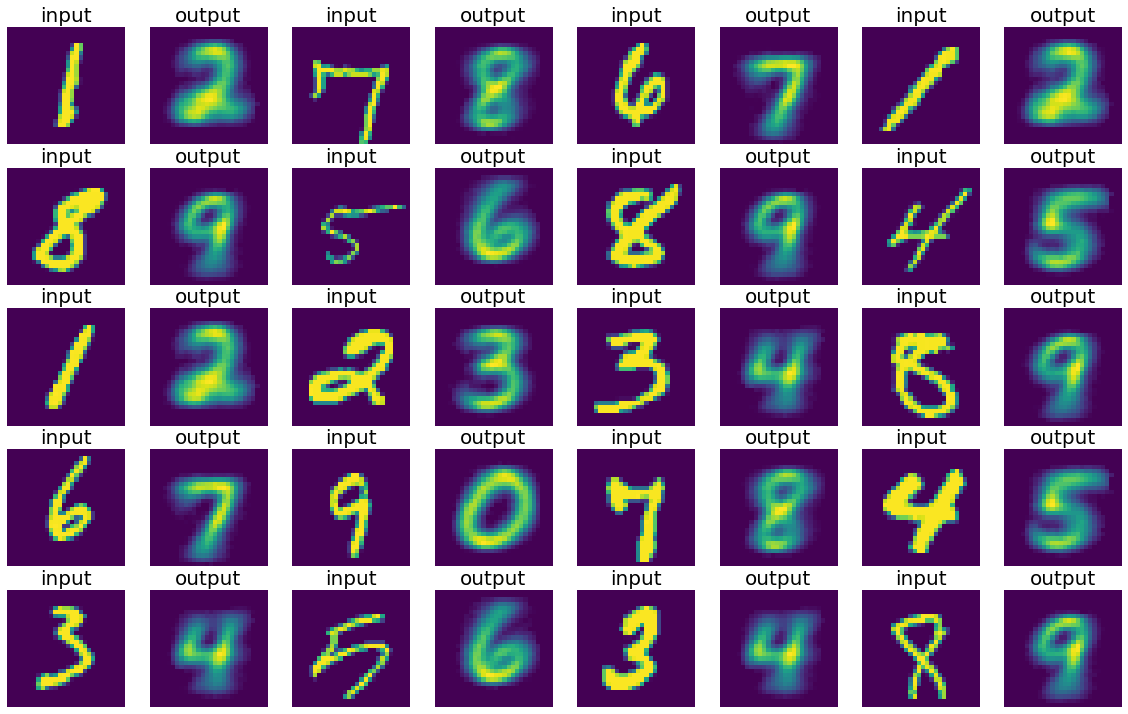

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [3]:
from Helper_codes.ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
#### IMPLEMENT YOUR MODEL ####
class NextDigitNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1),      # 1*28*28   -> 4*28*28
            nn.ReLU(),
            nn.Conv2d(4, 8, 3),                 # 4*28*28   -> 8*26*26
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),                # 8*26*26   -> 16*24*24
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                 # 16*24*24  -> 16*12*12
            nn.Dropout(p=0.5),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3),               # 16*12*12  -> 32*10*10
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),               # 32*10*10  -> 64*8*8
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                 # 64*8*8  -> 64*4*4
            nn.Dropout(p=0.5),
            nn.BatchNorm2d(64)
        )
        self.cnnT = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 5),      # 64*4*4    -> 32*8*8
            nn.ConvTranspose2d(32, 16, 5),      # 32*8*8    -> 16*12*12
            nn.ConvTranspose2d(16, 8, 5),       # 16*12*12  -> 8*16*16
            nn.ConvTranspose2d(8, 4, 5),        # 8*16*16   -> 4*20*20
            nn.ConvTranspose2d(4, 2, 5),        # 4*20*20   -> 2*24*24
            nn.ConvTranspose2d(2, 1, 5)         # 2*24*24   -> 1*28*28
        )
    
    def forward(self, x: torch.tensor):
        x = self.cnn(x)
        x = self.cnnT(x)
        return x

## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [6]:
class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [7]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [9]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####
model = NextDigitNet().to(device)

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.5)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [11]:
#### TRAIN/VAL FUNCTIONS ####
def train_epoch(model, dataloader):
    total_loss = 0
    i, N = 0, 0

    model.train()
    with tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (X, Y, y) in pbar:
            X = X.to(device).unsqueeze(1)
            Y = Y.to(device).unsqueeze(1)
            p = model(X)

            loss = criterion(Y, p)
            total_loss += float(loss) * dataloader.batch_size
            N += p.shape[0]

            pbar.set_description(f'Loss:{total_loss / N: .3e}')

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
    return total_loss

def val_epoch(model, dataloader):
    total_loss = 0
    i, N = 0, 0

    model.eval()
    with torch.no_grad(), tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (X, Y, y) in pbar:
            X = X.to(device).unsqueeze(1)
            Y = Y.to(device).unsqueeze(1)
            p = model(X)

            loss = criterion(Y, p)
            total_loss += float(loss) * dataloader.batch_size
            N += p.shape[0]

            pbar.set_description(f'Loss:{total_loss / N: .3e}')

    return total_loss

In [12]:
### Train/Val Model ###
num_epocs = 50

best_cost = float('inf')
state_dict = None

# train model
for e in range(num_epocs):

    train_loss = train_epoch(model, train_dataloader)
    val_loss = val_epoch(model, val_dataloader)
    scheduler.step()

    cost = train_loss
    if cost < best_cost:
        state_dict = model.state_dict()

    print(f'=====================[Epoch{e} Finished]======================\n')

Loss: 9.516e-02: 100%|██████████| 6/6 [00:00<00:00, 20.67it/s]


=====================[Epoch0 Finished]======================



Loss: 8.053e-02: 100%|██████████| 6/6 [00:00<00:00, 16.64it/s]


=====================[Epoch1 Finished]======================



Loss: 7.714e-02: 100%|██████████| 6/6 [00:00<00:00, 19.72it/s]


=====================[Epoch2 Finished]======================



Loss: 7.468e-02: 100%|██████████| 6/6 [00:00<00:00, 18.98it/s]


=====================[Epoch3 Finished]======================



Loss: 7.261e-02: 100%|██████████| 6/6 [00:00<00:00, 16.98it/s]


=====================[Epoch4 Finished]======================



Loss: 7.092e-02: 100%|██████████| 6/6 [00:00<00:00, 20.25it/s]


=====================[Epoch5 Finished]======================



Loss: 6.966e-02: 100%|██████████| 6/6 [00:00<00:00, 20.73it/s]


=====================[Epoch6 Finished]======================



Loss: 6.854e-02: 100%|██████████| 6/6 [00:00<00:00, 13.27it/s]


=====================[Epoch7 Finished]======================



Loss: 6.770e-02: 100%|██████████| 6/6 [00:00<00:00, 20.29it/s]


=====================[Epoch8 Finished]======================



Loss: 6.690e-02: 100%|██████████| 6/6 [00:00<00:00, 20.27it/s]


=====================[Epoch9 Finished]======================



Loss: 6.635e-02: 100%|██████████| 6/6 [00:00<00:00, 20.42it/s]


=====================[Epoch10 Finished]======================



Loss: 6.574e-02: 100%|██████████| 6/6 [00:00<00:00, 16.87it/s]


=====================[Epoch11 Finished]======================



Loss: 6.531e-02: 100%|██████████| 6/6 [00:00<00:00, 20.60it/s]


=====================[Epoch12 Finished]======================



Loss: 6.486e-02: 100%|██████████| 6/6 [00:00<00:00, 19.21it/s]


=====================[Epoch13 Finished]======================



Loss: 6.456e-02: 100%|██████████| 6/6 [00:00<00:00, 20.89it/s]


=====================[Epoch14 Finished]======================



Loss: 6.418e-02: 100%|██████████| 6/6 [00:00<00:00, 19.12it/s]


=====================[Epoch15 Finished]======================



Loss: 6.392e-02: 100%|██████████| 6/6 [00:00<00:00, 20.28it/s]


=====================[Epoch16 Finished]======================



Loss: 6.370e-02: 100%|██████████| 6/6 [00:00<00:00, 19.37it/s]


=====================[Epoch17 Finished]======================



Loss: 6.353e-02: 100%|██████████| 6/6 [00:00<00:00, 20.24it/s]


=====================[Epoch18 Finished]======================



Loss: 6.325e-02: 100%|██████████| 6/6 [00:00<00:00, 20.28it/s]


=====================[Epoch19 Finished]======================



Loss: 6.315e-02: 100%|██████████| 6/6 [00:00<00:00, 20.60it/s]


=====================[Epoch20 Finished]======================



Loss: 6.303e-02: 100%|██████████| 6/6 [00:00<00:00, 19.49it/s]


=====================[Epoch21 Finished]======================



Loss: 6.300e-02: 100%|██████████| 6/6 [00:00<00:00, 20.35it/s]


=====================[Epoch22 Finished]======================



Loss: 6.290e-02: 100%|██████████| 6/6 [00:00<00:00, 20.04it/s]


=====================[Epoch23 Finished]======================



Loss: 6.285e-02: 100%|██████████| 6/6 [00:00<00:00, 20.10it/s]


=====================[Epoch24 Finished]======================



Loss: 6.281e-02: 100%|██████████| 6/6 [00:00<00:00, 19.61it/s]


=====================[Epoch25 Finished]======================



Loss: 6.273e-02: 100%|██████████| 6/6 [00:00<00:00, 20.50it/s]


=====================[Epoch26 Finished]======================



Loss: 6.265e-02: 100%|██████████| 6/6 [00:00<00:00, 20.47it/s]


=====================[Epoch27 Finished]======================



Loss: 6.260e-02: 100%|██████████| 6/6 [00:00<00:00, 19.85it/s]


=====================[Epoch28 Finished]======================



Loss: 6.253e-02: 100%|██████████| 6/6 [00:00<00:00, 20.36it/s]


=====================[Epoch29 Finished]======================



Loss: 6.247e-02: 100%|██████████| 6/6 [00:00<00:00, 20.60it/s]


=====================[Epoch30 Finished]======================



Loss: 6.243e-02: 100%|██████████| 6/6 [00:00<00:00, 18.85it/s]


=====================[Epoch31 Finished]======================



Loss: 6.240e-02: 100%|██████████| 6/6 [00:00<00:00, 20.12it/s]


=====================[Epoch32 Finished]======================



Loss: 6.234e-02: 100%|██████████| 6/6 [00:00<00:00, 20.47it/s]


=====================[Epoch33 Finished]======================



Loss: 6.226e-02: 100%|██████████| 6/6 [00:00<00:00, 19.87it/s]


=====================[Epoch34 Finished]======================



Loss: 6.224e-02: 100%|██████████| 6/6 [00:00<00:00, 19.02it/s]


=====================[Epoch35 Finished]======================



Loss: 6.222e-02: 100%|██████████| 6/6 [00:00<00:00, 19.65it/s]


=====================[Epoch36 Finished]======================



Loss: 6.215e-02: 100%|██████████| 6/6 [00:00<00:00, 19.59it/s]


=====================[Epoch37 Finished]======================



Loss: 6.213e-02: 100%|██████████| 6/6 [00:00<00:00, 18.63it/s]


=====================[Epoch38 Finished]======================



Loss: 6.207e-02: 100%|██████████| 6/6 [00:00<00:00, 18.95it/s]


=====================[Epoch39 Finished]======================



Loss: 6.203e-02: 100%|██████████| 6/6 [00:00<00:00, 19.73it/s]


=====================[Epoch40 Finished]======================



Loss: 6.201e-02: 100%|██████████| 6/6 [00:00<00:00, 19.47it/s]


=====================[Epoch41 Finished]======================



Loss: 6.199e-02: 100%|██████████| 6/6 [00:00<00:00, 19.55it/s]


=====================[Epoch42 Finished]======================



Loss: 6.197e-02: 100%|██████████| 6/6 [00:00<00:00, 19.50it/s]


=====================[Epoch43 Finished]======================



Loss: 6.197e-02: 100%|██████████| 6/6 [00:00<00:00, 19.62it/s]


=====================[Epoch44 Finished]======================



Loss: 6.195e-02: 100%|██████████| 6/6 [00:00<00:00, 19.59it/s]


=====================[Epoch45 Finished]======================



Loss: 6.195e-02: 100%|██████████| 6/6 [00:00<00:00, 19.52it/s]


=====================[Epoch46 Finished]======================



Loss: 6.190e-02: 100%|██████████| 6/6 [00:00<00:00, 19.34it/s]


=====================[Epoch47 Finished]======================



Loss: 6.190e-02: 100%|██████████| 6/6 [00:00<00:00, 20.01it/s]


=====================[Epoch48 Finished]======================



Loss: 6.187e-02: 100%|██████████| 6/6 [00:00<00:00, 19.72it/s]

=====================[Epoch49 Finished]======================



In [13]:
# store best epoch state dictionary
file_name = 'next_digit.pth'
torch.save(state_dict, file_name)

## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [14]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####
model.load_state_dict(torch.load(file_name))

<All keys matched successfully>

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

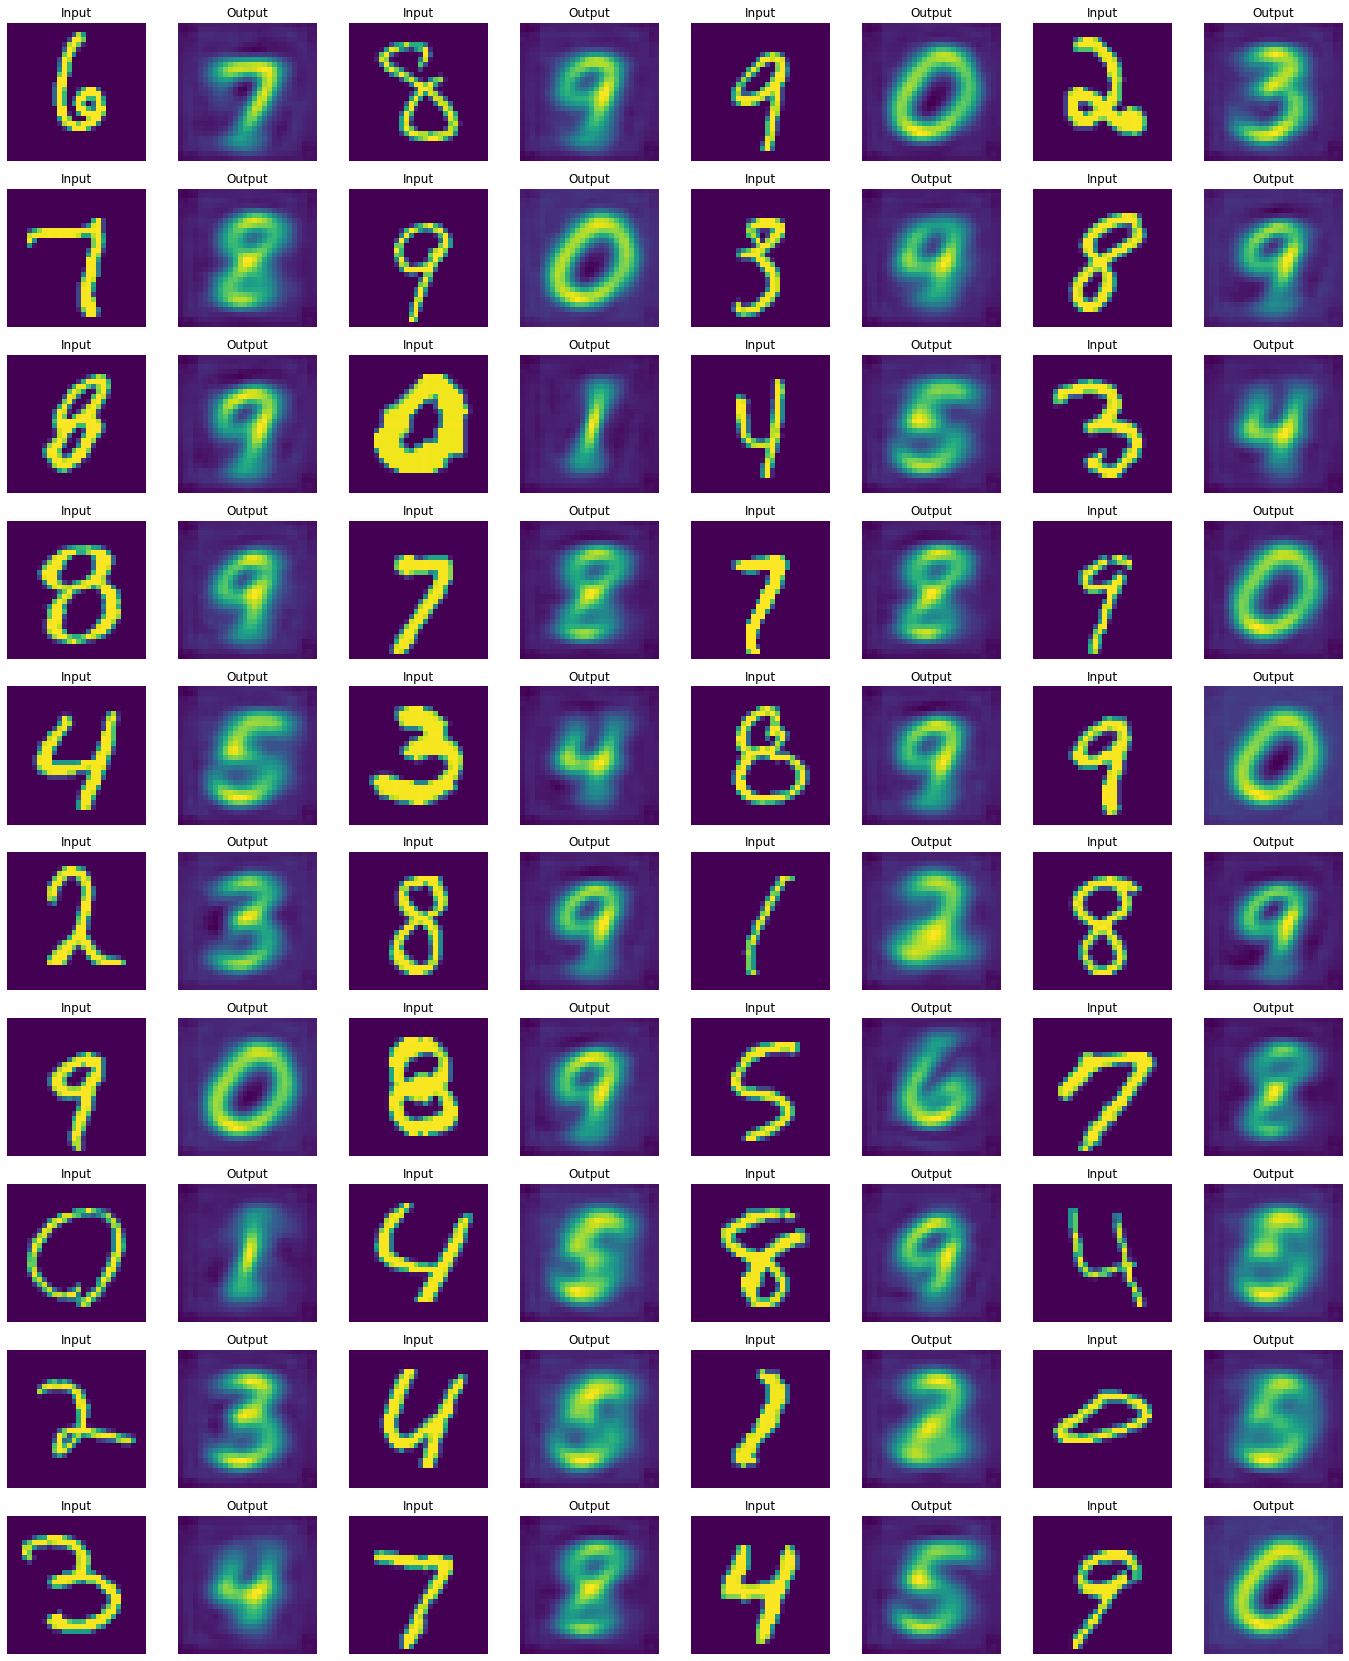

In [15]:
#### VISUALIZE YOUR MODEL ####
idxs = np.random.choice(range(X_test.shape[0]), size=40, replace=False)

fig = plt.figure(figsize=(24, 30))

i = 0
while i < 80:
    fig.add_subplot(10, 8, i + 1)
    X = X_test[idxs[i//2]]
    X = torch.from_numpy(X).to(device).unsqueeze(0)
    plt.imshow(X.cpu()[0])
    plt.title('Input')
    plt.axis('off')

    i += 1
    fig.add_subplot(10, 8, i + 1)
    Y = model(X.unsqueeze(0)).cpu().detach().numpy()
    plt.imshow(Y[0][0])
    plt.title('Output')
    plt.axis('off')
    
    i += 1